In [1]:
import os
import ast
import wfdb
import numpy as np
import pandas as pd

os.chdir("../..")
import utils

In [2]:
outputfolder = os.getcwd() + '/output/'
datafolder = os.getcwd() + '/datasets/PTB-XL/'
sampling_rate = 100
task = 'subdiagnostic'
experiment_name = 'exp1.1'

In [3]:
data, raw_labels = utils.load_dataset(datafolder, sampling_rate=sampling_rate)
labels = utils.compute_label_aggregations(raw_labels, datafolder, task)
data, labels, Y, _ = utils.select_data(data, labels, task, 0, outputfolder+experiment_name+'/data/')

In [4]:
X_test = data[labels.strat_fold == 10]
y_test = Y[labels.strat_fold == 10]

X_val = data[labels.strat_fold == 9]
y_val = Y[labels.strat_fold == 9]

X_train = data[labels.strat_fold <= 8]
y_train = Y[labels.strat_fold <= 8]

n_classes = y_train.shape[1]

print(f"This experiment has {n_classes} classes")

This experiment has 23 classes


In [5]:
X_train_lead1 = X_train[:,:,0]
X_test_lead1 = X_test[:,:,0]
X_val_lead1 = X_val[:,:,0]

# Fit LSTM

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, Dropout, Activation, BatchNormalization, LSTM
from keras.models import Sequential, Model
from keras.utils import plot_model
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt

In [7]:
lstm = Sequential()
lstm.add(LSTM(64, input_shape=(1000,12), return_sequences=True))
lstm.add(LSTM(64))
lstm.add(Dense(32, activation='relu'))
lstm.add(Dropout(0.3))
lstm.add(Dense(n_classes, activation='sigmoid'))

In [8]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', patience=3, verbose=1, min_delta=0, mode='max')

In [9]:
lstm.compile(loss=tf.keras.losses.BinaryCrossentropy(),
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
             metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy',threshold=0.5),
                      tf.keras.metrics.Recall(name='recall'),
                      tf.keras.metrics.AUC(num_thresholds=200,
                                           curve="ROC",
                                           summation_method='interpolation',
                                           name="AUC",
                                           multi_label=True,
                                           label_weights=None)])

In [10]:
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1000, 64)          19712     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 23)                759       
                                                                 
Total params: 55,575
Trainable params: 55,575
Non-trainable params: 0
_________________________________________________________________


In [11]:
batch_size = 10
lstm.fit(X_train, y_train, batch_size=batch_size, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
1709/1709 [==============================] - 3971s 1s/step - loss: 0.2025 - accuracy: 0.9324 - recall: 0.0962 - AUC: 0.5061 - val_loss: 0.1816 - val_accuracy: 0.9388 - val_recall: 0.0000e+00 - val_AUC: 0.5015
Epoch 2/50
1709/1709 [==============================] - 3876s 2s/step - loss: 0.1888 - accuracy: 0.9380 - recall: 0.0293 - AUC: 0.4958 - val_loss: 0.1803 - val_accuracy: 0.9387 - val_recall: 0.0000e+00 - val_AUC: 0.5266
Epoch 3/50
1709/1709 [==============================] - 1998s 1s/step - loss: 0.1857 - accuracy: 0.9382 - recall: 0.0091 - AUC: 0.5198 - val_loss: 0.1815 - val_accuracy: 0.9388 - val_recall: 0.0000e+00 - val_AUC: 0.5238
Epoch 4/50
1709/1709 [==============================] - 2196s 1s/step - loss: 0.1821 - accuracy: 0.9391 - recall: 0.0757 - AUC: 0.5453 - val_loss: 0.1694 - val_accuracy: 0.9424 - val_recall: 0.2675 - val_AUC: 0.6270
Epoch 5/50
1709/1709 [==============================] - 2330s 1s/step - loss: 0.1703 - accuracy: 0.9428 - recall: 0.2233 - A

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1000, 64)          19712     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 23)                759       
                                                                 
Total params: 55,575
Trainable params: 55,575
Non-trainable params: 0


_________________________________________________________________


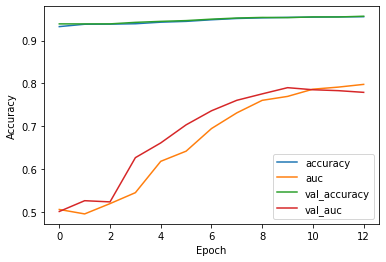

In [13]:
plt.plot(lstm.history.history['accuracy'])
plt.plot(lstm.history.history['AUC'])
plt.plot(lstm.history.history['val_accuracy'])
plt.plot(lstm.history.history['val_AUC'])
plt.legend(("accuracy","auc", "val_accuracy", "val_auc"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

lstm.summary()

In [14]:
ann_preds_test = lstm.predict(X_test)

roc_auc_score(y_test, ann_preds_test)

68/68 [==============================] - 15s 202ms/step


0.8163255636167716